In [1]:
import os
import sys
from hydra import initialize, compose
import matplotlib.pyplot as plt
import pysiaf
from pysiaf.utils.rotations import attitude
from pprint import pprint
import numpy as np
import webbpsf
import matplotlib.patches as patches
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import transforms
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
import PIL

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import plot_util
from mejiro.utils import util
from mejiro.helpers import psf

In [2]:
zernikes = np.load(os.path.join(config.machine.data_dir, 'output', 'zernikes', 'sum_z4_z22.npy'))

output_dir = os.path.join(config.machine.repo_dir, 'paper', 'graphics', 'zernikes')
util.create_directory_if_not_exists(output_dir)
util.clear_directory(output_dir)

z_min = np.min(zernikes)
z_max = np.max(zernikes)

for i, array in enumerate(zernikes):
    i += 1
    matplotlib.image.imsave(os.path.join(output_dir, f'sca{str(i).zfill(2)}.png'), array, vmin=z_min, vmax=z_max)

In [3]:
# Read in the Roman SIAF
rsiaf = pysiaf.Siaf('Roman')
 
# Print information about the WFI01_FULL aperture
wfi01 = rsiaf['WFI01_FULL']
print(f'WFI01 Xsci Ref: {wfi01.XSciRef}')
print(f'WFI01 Ysci Ref: {wfi01.YSciRef}')
print(f'WFI01 V2 Ref: {wfi01.V2Ref}')
print(f'WFI01 V3 Ref: {wfi01.V3Ref}')

WFI01 Xsci Ref: 2044.5
WFI01 Ysci Ref: 2044.5
WFI01 V2 Ref: 1312.9491452484797
WFI01 V3 Ref: -1040.7853726755036


In [4]:
# Plot the Roman apertures on the telescope ("V") frame
aperture_labels = [f'WFI{i + 1:02}_FULL' for i in range(18)]
roman_apertures = [rsiaf[rap] for rap in aperture_labels]
# roman_apertures.append('CGI_CEN')

labels = [f'SCA{str(i + 1).zfill(2)}' for i in range(18)]

In [5]:
band = 'F184'
oversample = 5

positions = [(4, 4092), (4, 4092), (2048, 2048), (1024, 3072), (3072, 1024)]
detectors = [4, 17, 1, 7, 15]

save_dir = os.path.join(data_dir, 'output', 'pysaif')
util.create_directory_if_not_exists(save_dir)
kernel_save = os.path.join(save_dir, 'kernels.npy')
if not os.path.exists(kernel_save):
    kernels = []
    for det, pos in zip(detectors, positions):
        if det == 4:
            kernels.append(psf.get_psf_kernel(band, det, pos, oversample=oversample, fov_arcsec=10))
        else:
            kernels.append(psf.get_psf_kernel(band, det, pos, oversample=oversample))
    np.save(kernel_save, kernels)
else:
    print('Loading cached PSF kernels')
    kernels = np.load(kernel_save, allow_pickle=True)

Loading cached PSF kernels


In [6]:
# delete cache
# util.clear_directory(save_dir)

In [7]:
residuals = [util.center_crop_image(kernels[0], (225, 225)) - i for i in kernels[1:]]
images = [kernels[0]] + residuals

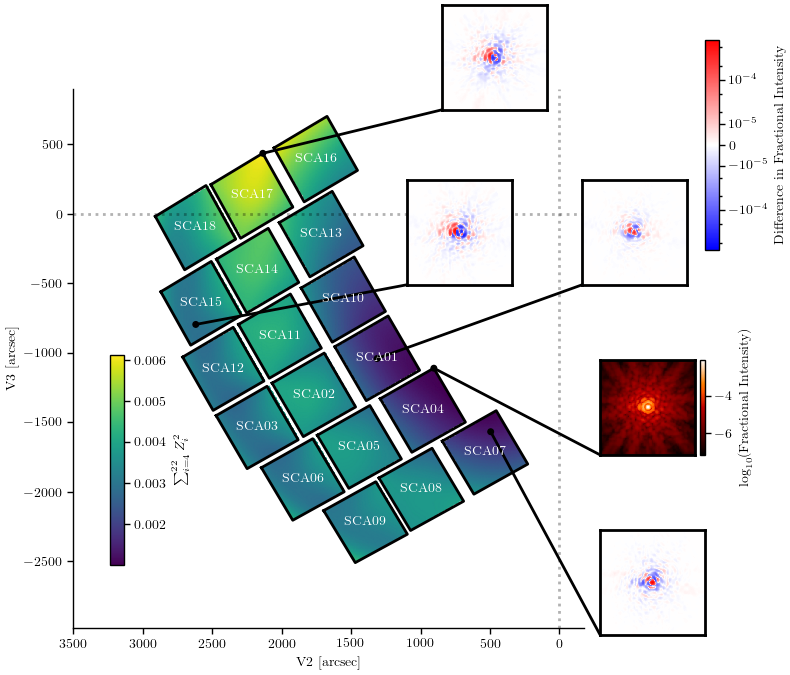

In [13]:
f, ax = plt.subplots(figsize=(7, 7))

zernike_bkg = np.asarray(PIL.Image.open(os.path.join(repo_dir, 'paper', 'graphics', 'zernike_bkg.png')))
 
for i, ap in enumerate(roman_apertures):
    ap.plot(frame='tel', label=False, units='arcsec', color='black')

    # label centers
    v2_ref = ap.V2Ref
    v3_ref = ap.V3Ref
    ax.text(v2_ref, v3_ref, labels[i], ha='center', va='center', color='white')

    # mark corners
    x_list, y_list = ap.corners('tel')
    coords = [(x, y) for x, y in zip(x_list, y_list)]
    colors = ['red', 'yellow', 'green', 'blue']
    # for c, color in zip(coords, colors):
    #     ax.plot(c[0], c[1], marker='o', color=color, markersize=5)

    # x2, y2 = ap.closed_polygon_points('tel')
    # # ax.fill(x2, y2)

    # width = np.sqrt(np.power(coords[0][0] - coords[1][0], 2) + np.power(coords[0][1] - coords[1][1], 2))
    # height = np.sqrt(np.power(coords[2][0] - coords[1][0], 2) + np.power(coords[2][1] - coords[1][1], 2))
    # # bottom_left = inv.transform((coords[0][0], coords[0][1]))
    # # bottom_right = inv.transform((coords[1][0], coords[1][1]))
    # # top_right = inv.transform((coords[2][0], coords[2][1]))
    # # top_left = inv.transform((coords[3][0], coords[3][1]))

    # # width = np.abs(bottom_left[0] - bottom_right[0])
    # # height = np.abs(top_left[1] - bottom_left[1])
    # print(width, height)

    # bbox = Bbox.from_bounds(0, 0, 1, 1)
    # bbox.rotate_deg(-60)
    # bbox_image = BboxImage(bbox, data=image)
    # ax.add_artist(bbox_image)

    
# mark PSF locations
marker_and_line_color = 'black'
inset_locations = [[0.9,0.35,0.15,0.15], [0.675,0.85,0.15,0.15], [0.875,0.6,0.15,0.15], [0.9,0.1,0.15,0.15], [0.625,0.6,0.15,0.15]]
patch_locations = [[(0,0), (44, 0)], [(0,0), (44, 0)], [(0,0), (44, 0)], [(0,0), (44, 0)], [(0,0), (44, 0)]]

# get v
v = plot_util.get_v(residuals)
norm = plot_util.get_norm(residuals, linear_width=8.5e-6)

for i, (det, pos, image, inset_location, patch_location) in enumerate(zip(detectors, positions, images, inset_locations, patch_locations)):
    v2, v3 = roman_apertures[det - 1].convert(*pos, from_frame='sci', to_frame='tel')
    circ_coords = (v2, v3)
    circ = patches.Circle(circ_coords, radius=20, color=marker_and_line_color)
    _ = ax.add_patch(circ)
    ax_inset = f.add_axes(inset_location, anchor='NE', zorder=1)

    if i == 0:
        rotated = util.rotate_array(np.log10(image), angle=60, fillcolor=0)
        cropped = util.center_crop_image(rotated, (225, 225))
        im = ax_inset.imshow(cropped, cmap='gist_heat')
        divider = make_axes_locatable(ax_inset)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = f.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_label(r'$\log_{10}(\textrm{Fractional Intensity})$')
    else:
        res = ax_inset.imshow(util.rotate_array(image, angle=60, fillcolor=0), cmap='bwr', norm=norm)

    ax_inset.spines[:].set_linewidth(2.)
    ax_inset.spines[:].set_color(marker_and_line_color)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    con_b = patches.ConnectionPatch(xyA=patch_location[0], coordsA=ax_inset.transData, xyB=circ_coords, coordsB=ax.transData, linewidth=2, color=marker_and_line_color)
    con_t = patches.ConnectionPatch(xyA=patch_location[1], coordsA=ax_inset.transData, xyB=circ_coords, coordsB=ax.transData, linewidth=2, color=marker_and_line_color)
    ax.add_artist(con_b)
    # ax.add_artist(con_t)

cax = f.add_axes([1.05, 0.65, 0.02, 0.3])
cbar = f.colorbar(res, cax=cax, orientation='vertical')
cbar.set_label('Difference in Fractional Intensity')
# ax.text(2750, 1000, 'Difference in Fractional Intensity', ha='left', va='center')

axis = ax.imshow(zernike_bkg, extent=[3500, 85, -2980, 900], zorder=-40)
norm = matplotlib.colors.Normalize(vmin=z_min, vmax=z_max) 
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm) 
cax = f.add_axes([0.2, 0.2, 0.02, 0.3])
cbar = f.colorbar(sm, cax=cax)
cbar.set_label(r'$\sum_{i=4}^{22}Z_i^2$')
# ax.text(2600, -1800, r'$\sum_{i=4}^{22}Z_i^2$', ha='center', va='center')
 
# Add guide lines for boresight (V2, V3) = (0, 0)
ax.axhline(0, color='black', linestyle=':', alpha=0.3)
ax.axvline(0, color='black', linestyle=':', alpha=0.3)
 
# invert the X-axis such that V2 is positive to the left
# ax.invert_xaxis()

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlabel('V2 [arcsec]')
ax.set_ylabel('V3 [arcsec]')

# print(ax.get_xlim(), ax.get_ylim())

# norm = matplotlib.colors.Normalize(vmin=0, vmax=2) 
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm) 
# sm.set_array([])
# plt.colorbar(sm)

plt.savefig(os.path.join(figure_dir, 'psfs_across_focal_plane.png'))
plt.show()

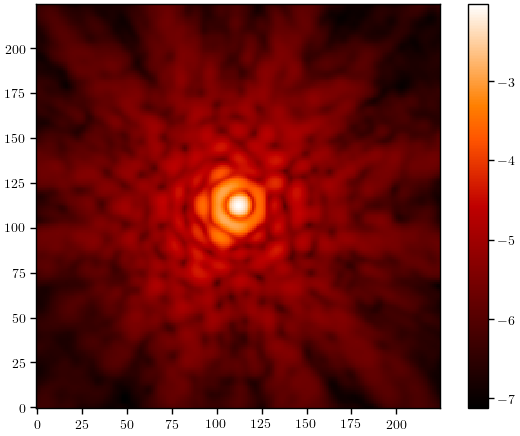

In [9]:
# double-check that the PSF has been rotated correctly: clockwise 60 deg
# below PSF is NOT rotated

plt.imshow(util.center_crop_image(np.log10(kernels[0]), (225, 225)), cmap='gist_heat')
plt.colorbar()
plt.show()